In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from datetime import datetime, timedelta
import time
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
os.environ["POLYGON_API_KEY"] = ""


POLYGON_API_KEY = os.getenv("POLYGON_API_KEY", "")
assert POLYGON_API_KEY, "Set POLYGON_API_KEY in your environment before running."

ALL_TICKERS = {
    'AI Infrastructure': ['NVDA', 'AMD', 'INTC', 'MU', 'CORW', 'NBIS', 'GOOGL'],
    'Robotics & Space': ['RKLB', 'JOBY', 'ACHR', 'TSLA'],
    'Crypto': ['COIN', 'HOOD', 'IBIT', 'IREN', 'CLSK'],
    'Quantum': ['IONQ', 'RGTI', 'QBTS', 'SMR', 'SERV']
}

FLAT_TICKERS = [t for sleeve in ALL_TICKERS.values() for t in sleeve]

START_DATE = '2020-01-01'
END_DATE = '2025-10-11'

INITIAL_CAPITAL = 100000
TOP_N_PER_SLEEVE = 2
LOOKBACK_PERIOD = 90

print("=" * 80)
print("ATTF CHECKPOINT A - POLYGON.IO DATA LOADER")
print("=" * 80)
print(f"Stocks to fetch: {len(FLAT_TICKERS)}")
print(f"Date range: {START_DATE} to {END_DATE}")
print()

ATTF CHECKPOINT A - POLYGON.IO DATA LOADER
Stocks to fetch: 21
Date range: 2020-01-01 to 2025-10-11



In [3]:
def fetch_polygon_data(ticker, start_date, end_date, api_key):
    """
    Fetch daily OHLC data from Polygon.io
    """
    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/day/{start_date}/{end_date}"
    params = {
        'adjusted': 'true',
        'sort': 'asc',
        'limit': 50000,
        'apiKey': api_key
    }
    
    try:
        response = requests.get(url, params=params)
        data = response.json()
        
        if 'results' not in data:
            print(f"[{ticker}] ❌ No data available")
            return None
        
        df = pd.DataFrame(data['results'])
        df['date'] = pd.to_datetime(df['t'], unit='ms')
        df = df.set_index('date')[['c']] 
        df.columns = [ticker]
        
        print(f"[{ticker}] ✅ {len(df)} days")
        return df[ticker]

    except Exception as e:
        print(f"[{ticker}] ❌ Error: {str(e)}")
        return None

print("📥 DOWNLOADING FROM POLYGON.IO:\n")

📥 DOWNLOADING FROM POLYGON.IO:



In [4]:
data_dict = {}
for ticker in FLAT_TICKERS:
    series = fetch_polygon_data(ticker, START_DATE, END_DATE, POLYGON_API_KEY)
    if series is not None:
        data_dict[ticker] = series
    time.sleep(0.15)

data = pd.DataFrame(data_dict)

print(f"\n{'='*80}")
print(f"✅ DATA LOADED")
print(f"{'='*80}")
print(f"Stocks: {len(data.columns)}/{len(FLAT_TICKERS)}")
print(f"Date range: {data.index[0].date()} to {data.index[-1].date()}")
print(f"Shape: {data.shape}")
print(f"\nFirst few rows:")
print(data.head())

[NVDA] ✅ 1452 days
[AMD] ✅ 1452 days
[INTC] ✅ 1452 days
[MU] ✅ 1452 days
[CORW] ❌ No data available
[NBIS] ✅ 244 days
[GOOGL] ✅ 1452 days
[RKLB] ✅ 1037 days
[JOBY] ✅ 1047 days
[ACHR] ✅ 1021 days
[TSLA] ✅ 1452 days
[COIN] ✅ 1130 days
[HOOD] ✅ 1056 days
[IBIT] ✅ 601 days
[IREN] ✅ 978 days
[CLSK] ✅ 1436 days
[IONQ] ✅ 1011 days
[RGTI] ✅ 907 days
[QBTS] ✅ 798 days
[SMR] ✅ 864 days
[SERV] ✅ 563 days

✅ DATA LOADED
Stocks: 20/21
Date range: 2020-01-02 to 2025-10-10
Shape: (1452, 20)

First few rows:
                       NVDA    AMD   INTC      MU  NBIS    GOOGL  RKLB  JOBY  \
date                                                                           
2020-01-02 05:00:00  5.9978  49.10  60.84  55.390   NaN  68.4340   NaN   NaN   
2020-01-03 05:00:00  5.9018  48.60  60.10  54.530   NaN  68.0760   NaN   NaN   
2020-01-06 05:00:00  5.9265  48.39  59.93  53.565   NaN  69.8905   NaN   NaN   
2020-01-07 05:00:00  5.9983  48.25  58.93  58.270   NaN  69.7555   NaN   NaN   
2020-01-08 05:00:00  6

In [5]:
missing = [t for t in FLAT_TICKERS if t not in data.columns]
if missing:
    print(f"\n⚠️  Missing tickers: {', '.join(missing)}")
    print("These will be excluded from analysis.")

data = data.fillna(method='ffill').fillna(method='bfill')

min_stocks_required = len(data.columns) * 0.5
data = data.dropna(thresh=min_stocks_required)

print(f"\n📊 After cleaning: {data.shape[0]} days with {data.shape[1]} stocks")

data.to_csv('attf_polygon_data.csv')
print(f"\n💾 Saved to 'attf_polygon_data.csv'")


⚠️  Missing tickers: CORW
These will be excluded from analysis.

📊 After cleaning: 1452 days with 20 stocks

💾 Saved to 'attf_polygon_data.csv'


In [6]:
def calculate_log_returns(prices):
    """Calculate log returns as per checkpoint assignment"""
    return 100 * np.log(prices / prices.shift(1))

def calculate_sharpe_ratio(returns, risk_free_rate=0.0):
    """Calculate annualized Sharpe ratio"""
    if returns.std() == 0:
        return 0
    excess_returns = returns - risk_free_rate
    return (excess_returns.mean() / excess_returns.std()) * np.sqrt(252)

def calculate_sortino_ratio(returns, risk_free_rate=0.0):
    """Calculate Sortino ratio (downside deviation only)"""
    excess_returns = returns - risk_free_rate
    downside_returns = excess_returns[excess_returns < 0]
    if len(downside_returns) == 0 or downside_returns.std() == 0:
        return 0
    return (excess_returns.mean() / downside_returns.std()) * np.sqrt(252)

def calculate_max_drawdown(equity_curve):
    """Calculate maximum drawdown"""
    cum_max = equity_curve.expanding().max()
    drawdown = (equity_curve - cum_max) / cum_max
    return drawdown.min()

def calculate_alpha_beta(portfolio_returns, benchmark_returns, risk_free_rate=0.0):
    """Calculate alpha and beta vs benchmark"""
    portfolio_returns, benchmark_returns = portfolio_returns.align(benchmark_returns, join='inner')
    
    if len(portfolio_returns) < 2:
        return 0, 0

    covariance = np.cov(portfolio_returns, benchmark_returns)[0][1]
    benchmark_variance = np.var(benchmark_returns)
    
    if benchmark_variance == 0:
        beta = 0
    else:
        beta = covariance / benchmark_variance

    portfolio_mean = portfolio_returns.mean() * 252
    benchmark_mean = benchmark_returns.mean() * 252
    alpha = portfolio_mean - (risk_free_rate + beta * (benchmark_mean - risk_free_rate))
    
    return alpha, beta

def calculate_metrics(portfolio_series, benchmark_series, initial_capital):
    """Calculate comprehensive performance metrics"""
    if len(portfolio_series) == 0:
        return {
            'total_return': 0, 'annual_return': 0, 'sharpe': 0,
            'sortino': 0, 'max_dd': 0, 'volatility': 0, 
            'alpha': 0, 'beta': 0
        }
    
    total_ret = (portfolio_series.iloc[-1] / initial_capital - 1) * 100
    days = len(portfolio_series)
    annual_ret = ((portfolio_series.iloc[-1] / initial_capital) ** (252 / days) - 1) * 100

    daily_ret = portfolio_series.pct_change().dropna()
    bench_ret = benchmark_series.pct_change().dropna()

    sharpe = calculate_sharpe_ratio(daily_ret)
    sortino = calculate_sortino_ratio(daily_ret)
    max_dd = calculate_max_drawdown(portfolio_series) * 100
    vol = daily_ret.std() * np.sqrt(252) * 100

    alpha, beta = calculate_alpha_beta(daily_ret, bench_ret)

    return {
        'total_return': total_ret,
        'annual_return': annual_ret,
        'sharpe': sharpe,
        'sortino': sortino,
        'max_dd': max_dd,
        'volatility': vol,
        'alpha': alpha * 100,  
        'beta': beta
    }

In [7]:
def calculate_momentum(data, date_idx, lookback):
    """Calculate momentum using only PRIOR data (no look-ahead bias)"""
    if date_idx <= lookback:
        return {ticker: -999 for ticker in data.columns}
    
    current_date = data.index[date_idx - 1]
    past_date = data.index[date_idx - 1 - lookback]
    
    momentum = {}
    for ticker in data.columns:
        try:
            momentum[ticker] = (data.loc[current_date, ticker] / data.loc[past_date, ticker]) - 1
        except:
            momentum[ticker] = -999
    return momentum

def select_top_per_sleeve(momentum, sleeves, top_n, available_tickers):
    """Select top N stocks per sleeve based on momentum"""
    selected = []
    for sleeve_name, sleeve_stocks in sleeves.items():
        sleeve_mom = {s: momentum.get(s, -999) for s in sleeve_stocks if s in available_tickers}
        if not sleeve_mom:
            continue
        top = sorted(sleeve_mom.items(), key=lambda x: x[1], reverse=True)[:top_n]
        selected.extend([s[0] for s in top])
    return selected

def backtest_strategy(data, sleeves, strategy_name, signal_func, rebalance_freq='M'):
    """
    Generic backtesting function with no look-ahead bias
    
    Parameters:
    - data: price DataFrame
    - sleeves: dict of sleeve -> tickers
    - strategy_name: string identifier
    - signal_func: function(data, date_idx) -> selected_tickers
    - rebalance_freq: 'M' for monthly, 'Q' for quarterly
    """
    
    data_temp = data.copy()
    data_temp['period'] = data_temp.index.to_period(rebalance_freq)
    rebalance_dates = data_temp.groupby('period').apply(lambda x: x.index[-1]).values
    
    portfolio_values = []
    dates_track = []
    holdings = {}

    for i, rebal_date in enumerate(rebalance_dates):
        rebal_idx = data.index.get_loc(rebal_date)
        
        if rebal_idx <= LOOKBACK_PERIOD:
            continue

        if holdings:
            current_value = sum(holdings[t] * data.loc[rebal_date, t] for t in holdings)
        else:
            current_value = INITIAL_CAPITAL

        selected = signal_func(data, rebal_idx, sleeves)
        
        if selected:
            weight = 1.0 / len(selected)
            new_holdings = {}
            for ticker in selected:
                allocation = current_value * weight
                price = data.loc[rebal_date, ticker]
                new_holdings[ticker] = allocation / price
            holdings = new_holdings

        if i + 1 < len(rebalance_dates):
            end_idx = data.index.get_loc(rebalance_dates[i + 1])
        else:
            end_idx = len(data) - 1
        
        for j in range(rebal_idx, end_idx + 1):
            date = data.index[j]
            value = sum(holdings[t] * data.iloc[j][t] for t in holdings) if holdings else current_value
            portfolio_values.append(value)
            dates_track.append(date)
    
    return pd.Series(portfolio_values, index=dates_track)

In [8]:
def walk_forward_validation(data, sleeves, train_window=252, test_window=63, step=63):
    """
    Walk-forward validation: train on train_window, test on test_window, 
    step forward by step days
    
    Parameters:
    - train_window: days to use for training (252 = 1 year)
    - test_window: days to test on (63 = 3 months)
    - step: days to move forward each iteration (63 = 3 months)
    """
    print(f"\n{'='*80}")
    print(f"WALK-FORWARD VALIDATION")
    print(f"{'='*80}")
    print(f"Train window: {train_window} days (~{train_window/252:.1f} years)")
    print(f"Test window: {test_window} days (~{test_window/252:.1f} years)")
    print(f"Step size: {step} days (~{step/252:.1f} years)")
    
    results = []
    portfolio_values = []
    dates_track = []
    
    start_idx = train_window
    holdings = {}

    while start_idx + test_window <= len(data):
        train_start = start_idx - train_window
        train_end = start_idx
        train_data = data.iloc[train_start:train_end]

        test_start = start_idx
        test_end = min(start_idx + test_window, len(data))
        test_data = data.iloc[test_start:test_end]
        
        print(f"\nWindow: Train {data.index[train_start].date()} to {data.index[train_end-1].date()}, "
              f"Test {data.index[test_start].date()} to {data.index[test_end-1].date()}")

        if holdings:
            current_value = sum(holdings[t] * data.iloc[test_start][t] for t in holdings)
        else:
            current_value = INITIAL_CAPITAL

        momentum = calculate_momentum(data, train_end, LOOKBACK_PERIOD)
        selected = select_top_per_sleeve(momentum, sleeves, TOP_N_PER_SLEEVE, data.columns)

        if selected:
            weight = 1.0 / len(selected)
            new_holdings = {}
            for ticker in selected:
                allocation = current_value * weight
                price = data.iloc[test_start][ticker]
                new_holdings[ticker] = allocation / price
            holdings = new_holdings

        for j in range(test_start, test_end):
            date = data.index[j]
            value = sum(holdings[t] * data.iloc[j][t] for t in holdings) if holdings else current_value
            portfolio_values.append(value)
            dates_track.append(date)

        test_values = portfolio_values[-len(range(test_start, test_end)):]
        test_return = (test_values[-1] / test_values[0] - 1) * 100 if test_values else 0

        results.append({
            'train_start': data.index[train_start].date(),
            'train_end': data.index[train_end-1].date(),
            'test_start': data.index[test_start].date(),
            'test_end': data.index[test_end-1].date(),
            'test_return': test_return,
            'selected_stocks': ', '.join(selected)
        })
        
        start_idx += step
    
    results_df = pd.DataFrame(results)
    portfolio_series = pd.Series(portfolio_values, index=dates_track)
    
    return portfolio_series, results_df

In [9]:
print(f"\n{'='*80}")
print("RUNNING BACKTESTS")
print(f"{'='*80}\n")

returns = data.pct_change()
benchmark_passive = (returns.mean(axis=1) + 1).cumprod() * INITIAL_CAPITAL

print(f"Benchmark length: {len(benchmark_passive)}")
print(f"Data shape: {data.shape}")
print(f"Available tickers: {list(data.columns)}")


RUNNING BACKTESTS

Benchmark length: 1452
Data shape: (1452, 20)
Available tickers: ['NVDA', 'AMD', 'INTC', 'MU', 'NBIS', 'GOOGL', 'RKLB', 'JOBY', 'ACHR', 'TSLA', 'COIN', 'HOOD', 'IBIT', 'IREN', 'CLSK', 'IONQ', 'RGTI', 'QBTS', 'SMR', 'SERV']


In [10]:
def momentum_90_signal(data, date_idx, sleeves):
    momentum = calculate_momentum(data, date_idx, 90)
    selected = select_top_per_sleeve(momentum, sleeves, TOP_N_PER_SLEEVE, data.columns)
    return selected

print("\nStrategy 1: Baseline Momentum (90-day lookback)...")
portfolio_1 = backtest_strategy(data, ALL_TICKERS, "S1: Baseline", momentum_90_signal)
print(f"  Portfolio 1 length: {len(portfolio_1)}")
if len(portfolio_1) > 0:
    print(f"  First value: ${portfolio_1.iloc[0]:,.2f}, Last value: ${portfolio_1.iloc[-1]:,.2f}")
metrics_1 = calculate_metrics(portfolio_1, benchmark_passive, INITIAL_CAPITAL)


Strategy 1: Baseline Momentum (90-day lookback)...
  Portfolio 1 length: 1415
  First value: $100,000.00, Last value: $2,010,582.77


In [11]:
def dual_momentum_signal(data, date_idx, sleeves):
    if date_idx <= 120:
        return []
    mom_60 = calculate_momentum(data, date_idx, 60)
    mom_120 = calculate_momentum(data, date_idx, 120)
    
    combined = {}
    for ticker in data.columns:
        if mom_60[ticker] > 0 and mom_120[ticker] > 0:
            combined[ticker] = (mom_60[ticker] + mom_120[ticker]) / 2
        else:
            combined[ticker] = -999
    
    selected = select_top_per_sleeve(combined, sleeves, TOP_N_PER_SLEEVE, data.columns)
    return selected

In [12]:
print("\nStrategy 2: Dual Momentum (60 + 120 day)...")
portfolio_2 = backtest_strategy(data, ALL_TICKERS, "S2: Dual", dual_momentum_signal)
print(f"  Portfolio 2 length: {len(portfolio_2)}")
if len(portfolio_2) > 0:
    print(f"  First value: ${portfolio_2.iloc[0]:,.2f}, Last value: ${portfolio_2.iloc[-1]:,.2f}")
metrics_2 = calculate_metrics(portfolio_2, benchmark_passive, INITIAL_CAPITAL)


Strategy 2: Dual Momentum (60 + 120 day)...
  Portfolio 2 length: 1415
  First value: $100,000.00, Last value: $1,467,446.11


In [13]:
print("\nStrategy 3: Walk-Forward Validation...")
portfolio_wf, wf_results = walk_forward_validation(
    data, ALL_TICKERS, 
    train_window=252,
    test_window=63,  
    step=63           
)
print(f"  Portfolio WF length: {len(portfolio_wf)}")
print(f"  WF windows: {len(wf_results)}")
if len(portfolio_wf) > 0:
    print(f"  First value: ${portfolio_wf.iloc[0]:,.2f}, Last value: ${portfolio_wf.iloc[-1]:,.2f}")
metrics_wf = calculate_metrics(portfolio_wf, benchmark_passive, INITIAL_CAPITAL)

metrics_passive = calculate_metrics(benchmark_passive, benchmark_passive, INITIAL_CAPITAL)


Strategy 3: Walk-Forward Validation...

WALK-FORWARD VALIDATION
Train window: 252 days (~1.0 years)
Test window: 63 days (~0.2 years)
Step size: 63 days (~0.2 years)

Window: Train 2020-01-02 to 2020-12-30, Test 2020-12-31 to 2021-04-01

Window: Train 2020-04-02 to 2021-04-01, Test 2021-04-05 to 2021-07-01

Window: Train 2020-07-02 to 2021-07-01, Test 2021-07-02 to 2021-09-30

Window: Train 2020-10-01 to 2021-09-30, Test 2021-10-01 to 2021-12-30

Window: Train 2020-12-31 to 2021-12-30, Test 2021-12-31 to 2022-03-31

Window: Train 2021-04-05 to 2022-03-31, Test 2022-04-01 to 2022-07-01

Window: Train 2021-07-02 to 2022-07-01, Test 2022-07-05 to 2022-09-30

Window: Train 2021-10-01 to 2022-09-30, Test 2022-10-03 to 2022-12-30

Window: Train 2021-12-31 to 2022-12-30, Test 2023-01-03 to 2023-04-03

Window: Train 2022-04-01 to 2023-04-03, Test 2023-04-04 to 2023-07-05

Window: Train 2022-07-05 to 2023-07-05, Test 2023-07-06 to 2023-10-03

Window: Train 2022-10-03 to 2023-10-03, Test 2023-1

In [14]:
print(f"\n{'='*80}")
print("RESULTS SUMMARY")
print(f"{'='*80}\n")

results_df = pd.DataFrame({
    'Strategy': [
        'S1: Baseline Momentum',
        'S2: Dual Momentum',
        'S3: Walk-Forward',
        'B1: Equal Weight (Passive)'
    ],
    'Total Return (%)': [
        metrics_1['total_return'],
        metrics_2['total_return'],
        metrics_wf['total_return'],
        metrics_passive['total_return']
    ],
    'Annual Return (%)': [
        metrics_1['annual_return'],
        metrics_2['annual_return'],
        metrics_wf['annual_return'],
        metrics_passive['annual_return']
    ],
    'Sharpe': [
        metrics_1['sharpe'],
        metrics_2['sharpe'],
        metrics_wf['sharpe'],
        metrics_passive['sharpe']
    ],
    'Sortino': [
        metrics_1['sortino'],
        metrics_2['sortino'],
        metrics_wf['sortino'],
        metrics_passive['sortino']
    ],
    'Max DD (%)': [
        metrics_1['max_dd'],
        metrics_2['max_dd'],
        metrics_wf['max_dd'],
        metrics_passive['max_dd']
    ],
    'Volatility (%)': [
        metrics_1['volatility'],
        metrics_2['volatility'],
        metrics_wf['volatility'],
        metrics_passive['volatility']
    ],
    'Alpha (%)': [
        metrics_1['alpha'],
        metrics_2['alpha'],
        metrics_wf['alpha'],
        0 
    ],
    'Beta': [
        metrics_1['beta'],
        metrics_2['beta'],
        metrics_wf['beta'],
        1.0  
    ]
})

print(results_df.to_string(index=False))

results_df.to_csv('attf_checkpoint_a_results.csv', index=False)
wf_results.to_csv('attf_walkforward_details.csv', index=False)

print(f"\n✅ Saved results to 'attf_checkpoint_a_results.csv'")
print(f"✅ Saved walk-forward details to 'attf_walkforward_details.csv'")


RESULTS SUMMARY

                  Strategy  Total Return (%)  Annual Return (%)   Sharpe  Sortino  Max DD (%)  Volatility (%)  Alpha (%)     Beta
     S1: Baseline Momentum       1910.582766          70.651869 1.396254 2.223831  -63.793605       45.765268  15.862241 0.978257
         S2: Dual Momentum       1367.446111          61.344899 1.196233 1.880911  -69.915694       50.713099   5.391378 1.125605
          S3: Walk-Forward        487.322389          45.167283 1.035523 1.705229  -59.887489       46.333057  -1.374657 0.949044
B1: Equal Weight (Passive)       1025.199149          52.210556 1.255463 1.954515  -63.356673       39.831510   0.000000 1.000000

✅ Saved results to 'attf_checkpoint_a_results.csv'
✅ Saved walk-forward details to 'attf_walkforward_details.csv'



GENERATING CHARTS



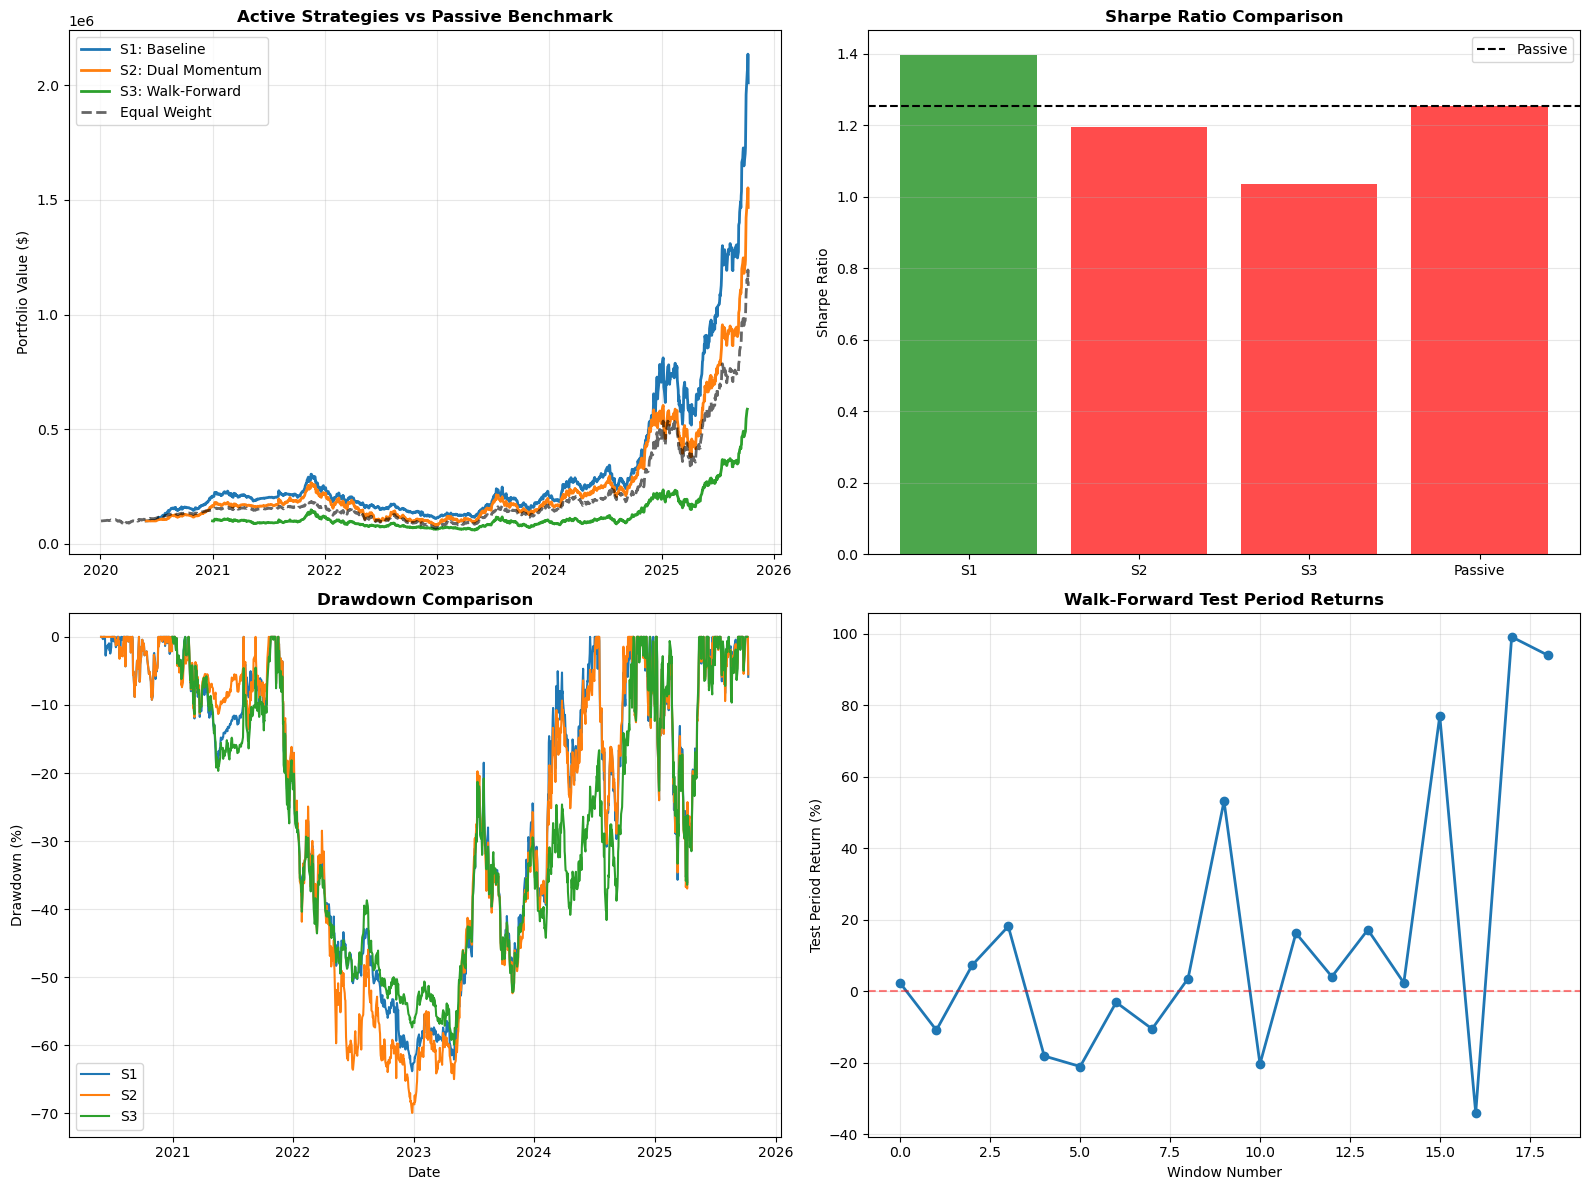

✅ Saved chart to 'attf_checkpoint_a_analysis.png'


In [15]:
print(f"\n{'='*80}")
print("GENERATING CHARTS")
print(f"{'='*80}\n")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

ax = axes[0, 0]
if len(portfolio_1) > 0:
    ax.plot(portfolio_1.index, portfolio_1.values, label='S1: Baseline', linewidth=2)
if len(portfolio_2) > 0:
    ax.plot(portfolio_2.index, portfolio_2.values, label='S2: Dual Momentum', linewidth=2)
if len(portfolio_wf) > 0:
    ax.plot(portfolio_wf.index, portfolio_wf.values, label='S3: Walk-Forward', linewidth=2)
ax.plot(benchmark_passive.index, benchmark_passive.values,
        label='Equal Weight', linewidth=2, linestyle='--', color='black', alpha=0.6)
ax.set_title('Active Strategies vs Passive Benchmark', fontweight='bold', fontsize=12)
ax.set_ylabel('Portfolio Value ($)')
ax.legend()
ax.grid(alpha=0.3)

ax = axes[0, 1]
strategies = ['S1', 'S2', 'S3', 'Passive']
sharpes = results_df['Sharpe'].values
colors = ['green' if s > metrics_passive['sharpe'] else 'red' for s in sharpes]
ax.bar(strategies, sharpes, color=colors, alpha=0.7)
ax.axhline(y=metrics_passive['sharpe'], color='black', linestyle='--', label='Passive')
ax.set_title('Sharpe Ratio Comparison', fontweight='bold', fontsize=12)
ax.set_ylabel('Sharpe Ratio')
ax.legend()
ax.grid(alpha=0.3, axis='y')

ax = axes[1, 0]
for portfolio, label in [(portfolio_1, 'S1'), (portfolio_2, 'S2'), (portfolio_wf, 'S3')]:
    if len(portfolio) > 0:
        cum_max = portfolio.expanding().max()
        dd = (portfolio - cum_max) / cum_max * 100
        ax.plot(dd.index, dd.values, label=label, linewidth=1.5)
ax.set_title('Drawdown Comparison', fontweight='bold', fontsize=12)
ax.set_ylabel('Drawdown (%)')
ax.set_xlabel('Date')
ax.legend()
ax.grid(alpha=0.3)

ax = axes[1, 1]
if len(wf_results) > 0:
    ax.plot(range(len(wf_results)), wf_results['test_return'].values, marker='o', linewidth=2)
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    ax.set_title('Walk-Forward Test Period Returns', fontweight='bold', fontsize=12)
    ax.set_ylabel('Test Period Return (%)')
    ax.set_xlabel('Window Number')
    ax.grid(alpha=0.3)
else:
    ax.text(0.5, 0.5, 'Insufficient data for walk-forward',
            ha='center', va='center', transform=ax.transAxes)

plt.tight_layout()
plt.savefig('attf_checkpoint_a_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved chart to 'attf_checkpoint_a_analysis.png'")

In [16]:
print(f"\n{'='*80}")
print("✅ CHECKPOINT A ANALYSIS COMPLETE")
print(f"{'='*80}")
print("\nKey Findings:")
print(f"- Best Strategy: {results_df.loc[results_df['Sharpe'].idxmax(), 'Strategy']}")
print(f"  Sharpe: {results_df['Sharpe'].max():.2f}")
print(f"  Total Return: {results_df.loc[results_df['Sharpe'].idxmax(), 'Total Return (%)']:.2f}%")
print(f"\n- Passive Benchmark:")
print(f"  Sharpe: {metrics_passive['sharpe']:.2f}")
print(f"  Total Return: {metrics_passive['total_return']:.2f}%")
print(f"\n- Alpha vs Passive (Best Strategy): {results_df['Alpha (%)'].max():.2f}%")


✅ CHECKPOINT A ANALYSIS COMPLETE

Key Findings:
- Best Strategy: S1: Baseline Momentum
  Sharpe: 1.40
  Total Return: 1910.58%

- Passive Benchmark:
  Sharpe: 1.26
  Total Return: 1025.20%

- Alpha vs Passive (Best Strategy): 15.86%
